Computing Wilcoxon vs best (e5_base + chain_ERCcv_lr)…
Saved: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/results/pvalues_vs_best.csv
Saved: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/results/table3_rrmse_grid.csv
Saved: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/results/table3_significance_grid.csv

Rendering all table variants …


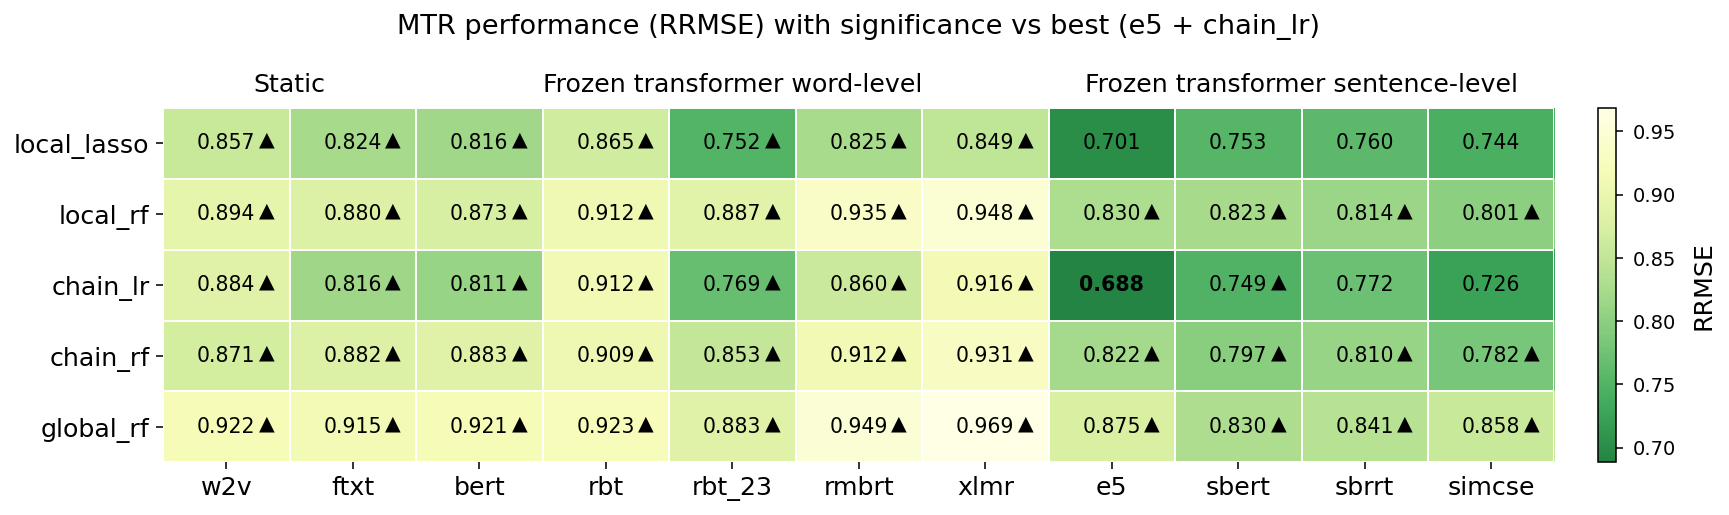

Saved figure: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_wilcoxon_heatmap.png
Saved figure: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_wilcoxon_heatmap.pdf
Wrote LaTeX table → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_wilcoxon_heatmap.tex


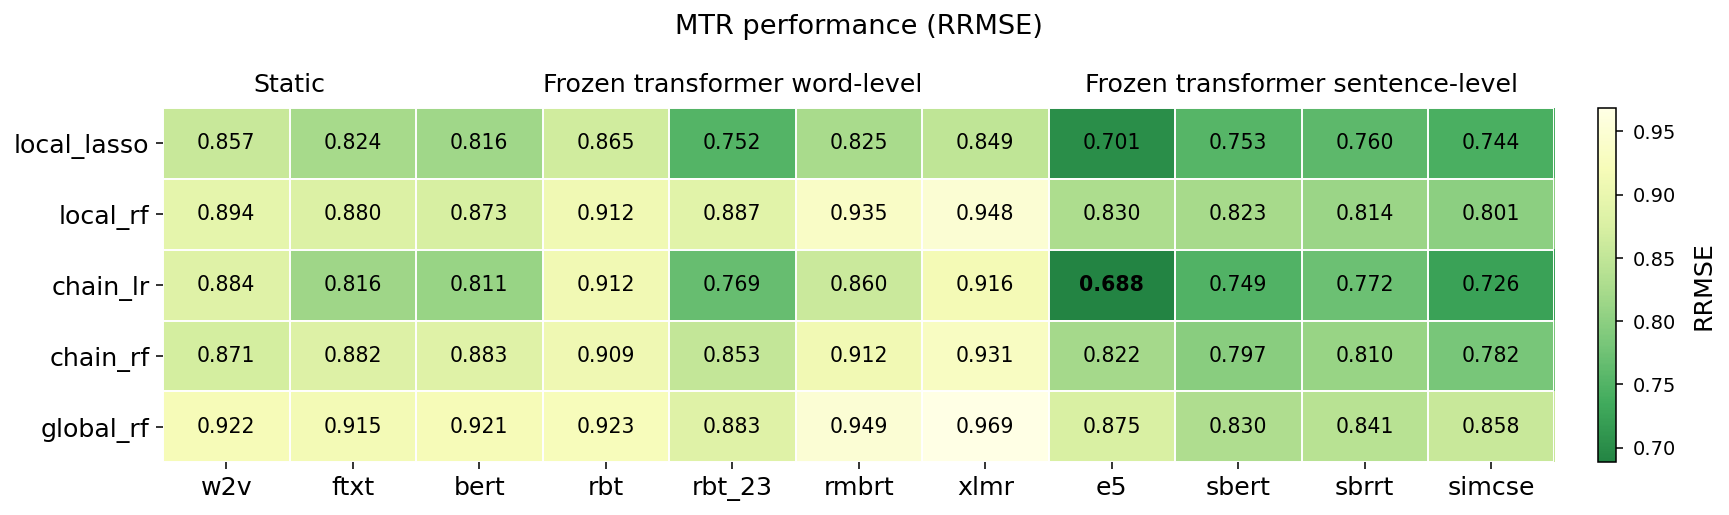

Saved figure: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_heatmap_no_triangles.png
Saved figure: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_heatmap_no_triangles.pdf
Wrote LaTeX table → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_heatmap_no_triangles.tex


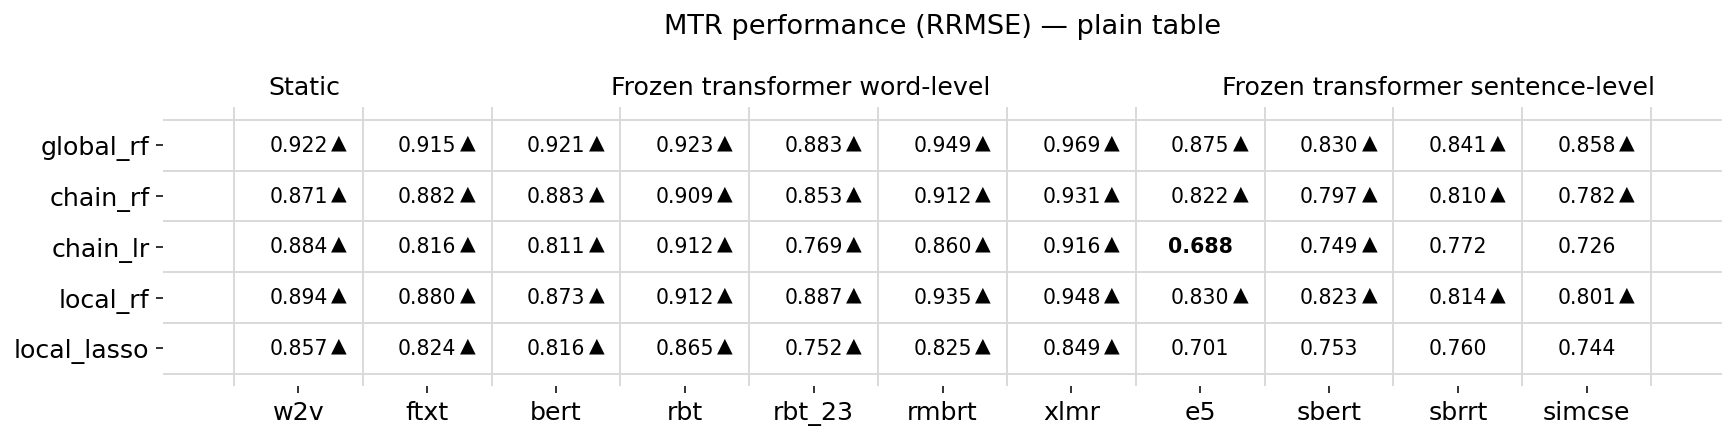

Saved figure: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_plain_with_triangles.png
Saved figure: /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_plain_with_triangles.pdf
Wrote LaTeX table → /Users/bertvos/Documents/Notebooks/kr8cht_review_anonymous/outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_plain_with_triangles.tex


In [1]:
"""
f_1_wilcoxon_heatmap.ipynb
───────────────────────────────────────────────────────────────────────────────
Pairwise Wilcoxon vs best (e5_base + chain_ERCcv_lr) over Table 3 configurations
and rendered tables/heatmaps for the Kr8cht pipeline.

This script:
1. Loads LOOCV RRMSE arrays previously saved by Step A (static embeddings) and
   Step B (frozen transformers).
2. Computes per-target medians (folds collapsed) and pairwise Wilcoxon signed-rank
   tests vs the best configuration (e5_base + chain_ERCcv_lr) with α=0.05
   (two-sided, zero_method="zsplit").
3. Builds the Table 3 layout in three variants:
   (i) heatmap with ▲ significance markers,
   (ii) heatmap without markers,
   (iii) plain table with ▲ markers.
4. Saves CSVs and LaTeX snippets and exports figures (PNG+PDF).

Inputs:
- outputs/a_static/results/baseline_word2vec_loocv_rrmse.npy
- outputs/a_static/results/baseline_fasttext_loocv_rrmse.npy
- outputs/b_frozen/results/{bert_mean,robbert_v2_mean,robbert2023_mean,rembert_mean,
                  xlmr_large_mean,e5_base,sbert_bert,sbert_roberta,simcse_xlmr_base}_loocv_rrmse.npy
  Each file stores a dict: model_key -> ndarray of shape (folds, targets=14).

Outputs:
- outputs/f_final_report/f_1_wilcoxon_heatmap/results/pvalues_vs_best.csv
- outputs/f_final_report/f_1_wilcoxon_heatmap/results/table3_rrmse_grid.csv
- outputs/f_final_report/f_1_wilcoxon_heatmap/results/table3_significance_grid.csv
- outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_wilcoxon_heatmap.{png,pdf,tex}
- outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_heatmap_no_triangles.{png,pdf,tex}
- outputs/f_final_report/f_1_wilcoxon_heatmap/tables/table3_plain_with_triangles.{png,pdf,tex}

"""

from __future__ import annotations

import warnings
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
from scipy.stats import wilcoxon

# ──────────────────────────────────────────────────────────────────────────────
# 0) Project roots & output dirs
# ──────────────────────────────────────────────────────────────────────────────

def get_project_root(marker: str = "LICENSE") -> Path:
    """Walk up from CWD to find repo root (file marker present)."""
    cwd = Path.cwd().resolve()
    for cand in (cwd, *cwd.parents):
        if (cand / marker).is_file():
            return cand
    return cwd

ROOT = get_project_root()

STATIC_RESULTS_IN = ROOT / "outputs" / "a_static" / "results"   
FROZEN_RESULTS_IN = ROOT / "outputs" / "b_frozen" / "results"   

OUT_BASE   = ROOT / "outputs" / "f_final_report" / "f_1_wilcoxon_heatmap"
OUT_RES    = OUT_BASE / "results"
OUT_TABLES = OUT_BASE / "tables"

for p in (OUT_RES, OUT_TABLES):
    p.mkdir(parents=True, exist_ok=True)

RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
warnings.filterwarnings("ignore", category=FutureWarning)

# ──────────────────────────────────────────────────────────────────────────────
# 1) Table 3 configuration (layout & naming)
# ──────────────────────────────────────────────────────────────────────────────

# External column labels (as in your LaTeX table header) → file/load keys
EMB_MAP = {
    # Static
    "w2v":   {"load_key": "baseline_word2vec"},
    "ftxt":  {"load_key": "baseline_fasttext"},

    # Frozen transformer (word-level, mean pooling)
    "bert":    {"load_key": "bert_mean"},
    "rbt":     {"load_key": "robbert_v2_mean"},
    "rbt_23":  {"load_key": "robbert2023_mean"},
    "rmbrt":   {"load_key": "rembert_mean"},
    "xlmr":    {"load_key": "xlmr_large_mean"},

    # Frozen transformer (sentence-level)
    "e5":      {"load_key": "e5_base"},
    "sbert":   {"load_key": "sbert_bert"},
    "sbrrt":   {"load_key": "sbert_roberta"},
    "simcse":  {"load_key": "simcse_xlmr_base"},
}

# Display row labels (left side of the table/plots)
ROW_BLOCKS = [
    ("Local",  ["local_lasso", "local_rf"]),
    ("Chain",  ["chain_lr", "chain_rf"]),
    ("Global", ["global_rf"]),
]

# Display label → key in saved results dicts
MODEL_KEY: Dict[str, str] = {
    "local_lasso": "local_lasso",
    "local_rf":  "local_rf",
    "chain_lr":  "chain_ERCcv_lr",
    "chain_rf":  "chain_ERCcv_rf",
    "global_rf": "global_rf",
}

# Column blocks (header groups) in order
COL_BLOCKS = [
    ("Static", ["w2v", "ftxt"]),
    ("Frozen transformer word-level", ["bert", "rbt", "rbt_23", "rmbrt", "xlmr"]),
    ("Frozen transformer sentence-level", ["e5", "sbert", "sbrrt", "simcse"]),
]

BEST_EMB_LABEL   = "e5"                 # as in the table
BEST_MODEL_LABEL = "chain_lr"
BEST_MODEL_KEY   = MODEL_KEY[BEST_MODEL_LABEL]
BEST_LOAD_KEY    = EMB_MAP[BEST_EMB_LABEL]["load_key"]

# ──────────────────────────────────────────────────────────────────────────────
# 2) Loading helpers and per-target aggregation
# ──────────────────────────────────────────────────────────────────────────────

def _load_rrmse_array(emb_label: str, model_key: str) -> np.ndarray:
    """
    Load LOOCV RRMSE array (folds × targets) for a given (embedding label, model key).
    Routes to a_static vs b_frozen based on the load_key.
    """
    load_key = EMB_MAP[emb_label]["load_key"]
    # Static goes to a_static; everything else to b_frozen
    base_dir = (
        STATIC_RESULTS_IN
        if load_key in {"baseline_word2vec", "baseline_fasttext"}
        else FROZEN_RESULTS_IN
    )
    npy = base_dir / f"{load_key}_loocv_rrmse.npy"
    if not npy.is_file():
        raise FileNotFoundError(f"Missing results file: {npy}")
    d = np.load(npy, allow_pickle=True).item()
    if model_key not in d:
        raise KeyError(f"Model '{model_key}' not in {npy.name}. Available: {list(d.keys())}")
    arr = d[model_key]
    if arr.ndim != 2:
        raise ValueError(f"Expected (folds, targets), got {arr.shape} in {npy.name}/{model_key}")
    return arr

def per_target_median(emb_label: str, model_disp_label: str) -> np.ndarray:
    """
    Per-target RRMSE vector by collapsing folds with median → shape (targets,).
    """
    model_key = MODEL_KEY[model_disp_label]
    arr = _load_rrmse_array(emb_label, model_key)     # (folds, targets)
    return np.median(arr, axis=0)                     # (targets,)

def scalar_rrmse_for_cell(emb_label: str, model_disp_label: str) -> float:
    """
    Scalar value for the displayed table cell:
    median over targets of the per-target medians (folds already collapsed).
    """
    vec = per_target_median(emb_label, model_disp_label)
    return float(np.median(vec))

# ──────────────────────────────────────────────────────────────────────────────
# 3) Wilcoxon vs best (per-target medians)
# ──────────────────────────────────────────────────────────────────────────────

def wilcoxon_vs_best(alpha: float = 0.05) -> pd.DataFrame:
    """
    For each (row, col) pair in Table 3, compute:
      - rrmse: scalar shown in the cell,
      - p_value: Wilcoxon signed-rank vs best (e5 + chain_ERCcv_lr), two-sided,
                 zero_method="zsplit",
      - significant: p < alpha,
      - direction: sign of median difference vs best (+ worse, - better, 0 tie).
    """
    best_vec = per_target_median(BEST_EMB_LABEL, BEST_MODEL_LABEL)  # (14,)
    records = []

    for block_name, row_labels in ROW_BLOCKS:
        for row_disp in row_labels:
            for group_name, col_labels in COL_BLOCKS:
                for col_disp in col_labels:
                    cell_val = scalar_rrmse_for_cell(col_disp, row_disp)
                    vec = per_target_median(col_disp, row_disp)

                    if np.allclose(vec - best_vec, 0):
                        p = 1.0
                    else:
                        _, p = wilcoxon(vec, best_vec, zero_method="zsplit")

                    med_diff = float(np.median(vec - best_vec))
                    records.append({
                        "row_block": block_name,
                        "row": row_disp,
                        "col_block": group_name,
                        "col": col_disp,
                        "rrmse": cell_val,
                        "p_value": float(p),
                        "alpha": alpha,
                        "significant": bool(p < alpha),
                        "direction": np.sign(med_diff),
                    })

    return pd.DataFrame.from_records(records)

# ──────────────────────────────────────────────────────────────────────────────
# 4) Table shaping & CSV saves
# ──────────────────────────────────────────────────────────────────────────────

def make_table_frames(df: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame]:
    """Return RRMSE grid and boolean significance grid in Table 3 order."""
    row_order = sum([rows for _, rows in ROW_BLOCKS], [])
    col_order = sum([cols for _, cols in COL_BLOCKS], [])
    values_df = df.pivot(index="row", columns="col", values="rrmse").reindex(index=row_order, columns=col_order)
    signif_df = df.pivot(index="row", columns="col", values="significant").reindex(index=row_order, columns=col_order)
    return values_df, signif_df

def save_results_csv(df_stats: pd.DataFrame, values_df: pd.DataFrame, signif_df: pd.DataFrame):
    df_stats.to_csv(OUT_RES / "pvalues_vs_best.csv", index=False)
    values_df.to_csv(OUT_RES / "table3_rrmse_grid.csv")
    signif_df.to_csv(OUT_RES / "table3_significance_grid.csv")
    print(f"Saved: {OUT_RES/'pvalues_vs_best.csv'}")
    print(f"Saved: {OUT_RES/'table3_rrmse_grid.csv'}")
    print(f"Saved: {OUT_RES/'table3_significance_grid.csv'}")

# ──────────────────────────────────────────────────────────────────────────────
# 5) Plotting
# ──────────────────────────────────────────────────────────────────────────────

def get_lightened_cmap(minfrac: float = 0.25):
    base = plt.get_cmap("YlGn_r", 256)
    return mpl.colors.LinearSegmentedColormap.from_list(
        "YlGn_r_trunc", base(np.linspace(minfrac, 1.0, 256))
    )

def _format_display_label(lbl: str) -> str:
    """For LaTeX output: return a safely escaped display label."""
    mapping = {
        "local_lasso": "local\\_lasso",
        "local_rf":  "local\\_rf",
        "chain_lr":  "chain\\_lr",
        "chain_rf":  "chain\\_rf",
        "global_rf": "global\\_rf",
    }
    return mapping.get(lbl, lbl.replace("_", "\\_"))

def plot_table(values_df: pd.DataFrame, signif_df: pd.DataFrame, *,
               title="MTR performance (RRMSE) with significance vs best (e5 + chain)",
               show_heatmap=True,
               show_triangles=True,
               save_stem="table3_wilcoxon_heatmap",
               # Font-size controls
               x_tick_fs: int = 10,
               y_tick_fs: int = 10,
               title_fs: int = 12,
               cell_fs: int = 9,
               group_fs: int = 10,
               cbar_label_fs: int = 11,
               cbar_tick_fs: int = 10,
               # Spacing controls (top + colorbar)
               group_y: float = 1.06,      # column-group labels vertical position (axes coords)
               title_pad: float = 34,      # distance between title and axes
               cbar_labelpad: int = 12,    # distance between cbar label and ticks
               cbar_tick_pad: int = 4,     # distance between cbar ticks and the bar
               # Triangle placement controls (inside cells)
               tri_dx_pts: float = 6.0,    # horizontal gap to the right of the number (in points)
               tri_dy_pts: float = 0.8,    # vertical raise for triangle (in points; >0 raises)
               tri_size_factor: float = 1.0,   # triangle size relative to number font
               tri_char: str = "▲"         # triangle glyph
               ):
    """
    Render Table 3 as:
      - heatmap + ▲ (show_heatmap=True, show_triangles=True)
      - heatmap only (show_heatmap=True, show_triangles=False)
      - plain table + ▲ (show_heatmap=False, show_triangles=True)

    Font sizes:
      - x_tick_fs, y_tick_fs  : axis tick labels
      - title_fs              : figure title
      - cell_fs               : numbers inside cells
      - group_fs              : column-group labels at the top
      - cbar_label_fs         : colorbar label
      - cbar_tick_fs          : colorbar tick labels

    Spacing:
      - group_y       : vertical position of column-group labels (in axes coords)
      - title_pad     : padding for title
      - cbar_labelpad : padding between colorbar label and its ticks
      - cbar_tick_pad : padding between colorbar ticks and the bar

    Triangle placement:
      - tri_dx_pts    : horizontal space between number and triangle (points)
      - tri_dy_pts    : vertical raise to align triangle baseline with digits (points)
      - tri_size_factor: size multiplier for the triangle relative to cell_fs
    """
    nrows, ncols = values_df.shape
    im = None
    if show_heatmap:
        vmin = float(np.nanmin(values_df.values))
        vmax = float(np.nanmax(values_df.values))

    fig_h = 4.2 if show_heatmap else 3.6
    fig, ax = plt.subplots(figsize=(12.5, fig_h), dpi=140)

    if show_heatmap:
        cm = get_lightened_cmap(minfrac=0.25)  # consistent with step_f_4
        im = ax.imshow(values_df.values, aspect="auto", vmin=vmin, vmax=vmax, cmap=cm)

    # Axis ticks / labels
    ax.set_xticks(np.arange(ncols))
    ax.set_xticklabels(values_df.columns, rotation=0, fontsize=x_tick_fs)
    ax.set_yticks(np.arange(nrows))
    ax.set_yticklabels(list(values_df.index), fontsize=y_tick_fs)

    # Grid lines around cells
    for i in range(nrows + 1):
        ax.axhline(i - 0.5, color=("white" if show_heatmap else "0.85"), lw=1)
    for j in range(ncols + 1):
        ax.axvline(j - 0.5, color=("white" if show_heatmap else "0.85"), lw=1)

    # Numbers inside cells (+ optional ▲ drawn as a separate text with offsets)
    for i in range(nrows):
        for j in range(ncols):
            val = float(values_df.iat[i, j])
            row_name = values_df.index[i]
            col_name = values_df.columns[j]
            is_best = (row_name == BEST_MODEL_LABEL) and (col_name == BEST_EMB_LABEL)

            # Draw the number centered in the cell
            ax.text(j, i, f"{val:.3f}",
                    ha="center", va="center",
                    fontsize=cell_fs, color="black",
                    fontweight=("bold" if is_best else "normal"))

            # If significant, overlay a triangle slightly to the right and (optionally) slightly raised
            if show_triangles and bool(signif_df.iat[i, j]):
                # Offset in points, independent of data coords / figure DPI
                trans = ax.transData + mpl.transforms.ScaledTranslation(
                    tri_dx_pts / 72.0, tri_dy_pts / 72.0, fig.dpi_scale_trans
                )
                ax.text(j, i, tri_char,
                        transform=trans,
                        ha="left", va="center",
                        fontsize=cell_fs * tri_size_factor,
                        color="black",
                        fontweight=("bold" if is_best else "normal"))

    # Column-group labels above the columns
    cum = 0
    for (grp_name, cols) in COL_BLOCKS:
        L = len(cols)
        center_norm = (cum + (L - 1) / 2 + 0.5) / ncols
        ax.text(center_norm, group_y, grp_name, transform=ax.transAxes,
                ha="center", va="bottom", fontsize=group_fs)
        cum += L

    # Title with adjustable padding
    ax.set_title(title, fontsize=title_fs, pad=title_pad)

    # Clean spines
    for s in ["top", "right", "left", "bottom"]:
        ax.spines[s].set_visible(False)

    # Colorbar on the right
    if show_heatmap:
        cbar = fig.colorbar(im, ax=ax, fraction=0.018, pad=0.03)
        cbar.set_label("RRMSE", rotation=90, va="center",
                       fontsize=cbar_label_fs, labelpad=cbar_labelpad)
        cbar.ax.tick_params(labelsize=cbar_tick_fs, pad=cbar_tick_pad)

    # Extra headroom for title + group labels
    plt.tight_layout(rect=[0, 0, 1, 0.90])

    png_path = OUT_TABLES / f"{save_stem}.png"
    pdf_path = OUT_TABLES / f"{save_stem}.pdf"
    plt.savefig(png_path, bbox_inches="tight")
    plt.savefig(pdf_path, bbox_inches="tight")
    plt.show()
    print(f"Saved figure: {png_path}\nSaved figure: {pdf_path}")


# ──────────────────────────────────────────────────────────────────────────────
# 6) LaTeX generation (variants)
# ──────────────────────────────────────────────────────────────────────────────

def _hex_from_val(val: float, vmin: float, vmax: float) -> str:
    cm = get_lightened_cmap(minfrac=0.25)  # match plot + step_f_4
    norm = mpl.colors.Normalize(vmin=vmin, vmax=vmax)
    rgba = cm(norm(val))
    rgb = tuple(int(round(255*x)) for x in rgba[:3])
    return "{:02X}{:02X}{:02X}".format(*rgb)

def write_latex_table(values_df: pd.DataFrame, signif_df: pd.DataFrame, path: Path, *,
                      colorize: bool = True,
                      include_sig: bool = True,
                      caption: str = None,
                      label: str = "tab:result_MTR_embed_variant"):
    """
    Write a LaTeX table snippet (heatmap/plain × with/without ▲).
    """
    vmin = float(np.nanmin(values_df.values))
    vmax = float(np.nanmax(values_df.values))

    def latex_cell(row_key: str, col_key: str) -> str:
        val = float(values_df.loc[row_key, col_key])
        is_best = (row_key == BEST_MODEL_LABEL) and (col_key == BEST_EMB_LABEL)
        sig = "\\sig" if (include_sig and bool(signif_df.loc[row_key, col_key])) else ""
        num = f"{val:.3f}{sig}"
        if colorize:
            hexcol = _hex_from_val(val, vmin, vmax)
            content = f"\\cellcolor[HTML]{{{hexcol}}}{num}"
        else:
            content = num
        return f"\\textbf{{{content}}}" if is_best else content

    if caption is None:
        parts = []
        parts.append("heatmap" if colorize else "plain")
        if include_sig:
            parts.append("$\\blacktriangle$ significant vs best")
        caption = "MTR performance (RRMSE): " + ", ".join(parts) + "."

    lines = []
    lines.append("% Auto-generated by step_f_2_wilcoxon_heatmap")
    lines.append("% \\usepackage{booktabs, multirow}")
    if colorize:
        lines.append("% \\usepackage[table]{xcolor}")
    lines.append("% \\usepackage{amssymb}")  # for \\blacktriangle
    lines.append("\\newcommand{\\sig}{\\raisebox{0.35ex}{\\tiny$\\blacktriangle$}}")
    lines.append("")
    lines.append("\\begin{table*}[t]")
    lines.append(f"\\caption{{{caption}}}")
    lines.append(f"\\label{{{label}}}")
    lines.append("\\setlength\\tabcolsep{6pt}")
    lines.append("\\renewcommand{\\arraystretch}{1.15}")
    lines.append("\\begin{tabular}{ll" + "l"*values_df.shape[1] + "}")
    lines.append("\\toprule")
    # Group header
    lines.append("\\cmidrule{3-" + str(2 + values_df.shape[1]) + "}")
    lines.append(" & & " + " & ".join([f"\\multicolumn{{{len(cols)}}}{{c}}{{{name}}}" for name, cols in COL_BLOCKS]) + " \\\\")
    # Column labels
    col_labels = [c for _, cols in COL_BLOCKS for c in cols]
    lines.append(" & & " + " & ".join(col_labels) + " \\\\")
    lines.append("\\midrule")

    # Rows
    for block_name, row_labels in ROW_BLOCKS:
        first = row_labels[0]
        row = " & ".join([_format_display_label(first)] + [latex_cell(first, c) for c in col_labels])
        lines.append(f"\\multirow{{{len(row_labels)}}}{{*}}{{{block_name}}} & {row} \\\\")
        for r in row_labels[1:]:
            row = " & ".join([_format_display_label(r)] + [latex_cell(r, c) for c in col_labels])
            lines.append(f" & {row} \\\\")
        if block_name != ROW_BLOCKS[-1][0]:
            lines.append("\\midrule")

    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    lines.append("\\end{table*}")

    path.write_text("\n".join(lines), encoding="utf-8")
    print(f"Wrote LaTeX table → {path}")

# ──────────────────────────────────────────────────────────────────────────────
# 7) Render all variants (figures + LaTeX)
# ──────────────────────────────────────────────────────────────────────────────

def rerender_all_variants(values_df: pd.DataFrame, signif_df: pd.DataFrame, **size_kw):
    """Render the three figure/table variants, forwarding any size/spacing kwargs."""
    # 1) Heatmap + triangles
    plot_table(values_df, signif_df,
               title="MTR performance (RRMSE) with significance vs best (e5 + chain_lr)",
               show_heatmap=True, show_triangles=True,
               save_stem="table3_wilcoxon_heatmap",
               **size_kw)
    write_latex_table(values_df, signif_df,
                      OUT_TABLES / "table3_wilcoxon_heatmap.tex",
                      colorize=True, include_sig=True,
                      caption="MTR performance (RRMSE) with heatmap; ▲ marks Wilcoxon $p<0.05$ vs best (e5 + chain).",
                      label="tab:result_MTR_embed_sig_heatmap")

    # 2) Heatmap without triangles
    plot_table(values_df, signif_df,
               title="MTR performance (RRMSE)",
               show_heatmap=True, show_triangles=False,
               save_stem="table3_heatmap_no_triangles",
               **size_kw)
    write_latex_table(values_df, signif_df,
                      OUT_TABLES / "table3_heatmap_no_triangles.tex",
                      colorize=True, include_sig=False,
                      caption="MTR performance (RRMSE) with heatmap (no significance markers).",
                      label="tab:result_MTR_embed_heatmap_only")

    # 3) Plain table + triangles
    plot_table(values_df, signif_df,
               title="MTR performance (RRMSE) — plain table",
               show_heatmap=False, show_triangles=True,
               save_stem="table3_plain_with_triangles",
               **size_kw)
    write_latex_table(values_df, signif_df,
                      OUT_TABLES / "table3_plain_with_triangles.tex",
                      colorize=False, include_sig=True,
                      caption="MTR performance (RRMSE) as plain table; ▲ marks Wilcoxon $p<0.05$ vs best (e5 + chain).",
                      label="tab:result_MTR_embed_plain_sig")

# ──────────────────────────────────────────────────────────────────────────────
# 8) Main
# ──────────────────────────────────────────────────────────────────────────────

def main(alpha: float = 0.05):
    print("Computing Wilcoxon vs best (e5_base + chain_ERCcv_lr)…")
    df_stats = wilcoxon_vs_best(alpha=alpha)
    values_df, signif_df = make_table_frames(df_stats)
    save_results_csv(df_stats, values_df, signif_df)

    print("\nRendering all table variants …")
    # Example tuning that typically looks good; adjust to taste.
    rerender_all_variants(
        values_df, signif_df,
        # text sizes
        x_tick_fs=13,
        y_tick_fs=13,
        title_fs=14,
        cell_fs=10.5,
        group_fs=13,
        cbar_label_fs=13,
        cbar_tick_fs=10,
        # top spacing
        group_y=1.03,    # move group labels slightly down
        title_pad=38,    # push title further up
        # colorbar spacing
        cbar_labelpad=14,
        cbar_tick_pad=5,
        # triangle spacing & alignment
        tri_dx_pts=16.7,  # short space between number and triangle
        tri_dy_pts=1.9,  # tiny raise to match number baseline
        tri_size_factor=1.0
    )

if __name__ == "__main__":
    main(alpha=0.05)

